# Project
## Jonathan Sahagun , Jose Ambrosio

imports

In [1]:
import cv2
import os
import numpy as np
import pip  
#pip.main(['install', 'imutils'])
from random import shuffle
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
# import data_generator as dg
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from copy import deepcopy, copy;
from os.path import isfile, join
%matplotlib inline

Help functions and vars

In [2]:
# Thanks Mark
minDim = 80
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

dims = (minDim, minDim)

hog = cv2.HOGDescriptor(dims, blockSize, blockStride, cellSize, nbins)

def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data

#helper function for resizing images
def resize(img, scale):
    return cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

def preprocess(image, lower, upper):
    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    #This takes image[x] and image[x] when mask is 1 (that is, it leaves it alone),
    #otherwise it makes image[x] = 0. The effect in this case is just image and mask. 
    #This is applied to all 3 channels
    
    return output, mask

def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), int(x[2]*factor), int(x[3]*factor)] for x in boxes]

Function that reads the plate. Is discussed later.

In [3]:
def readPlate(image, threshold = .01, verbose = False):
    pimage, mask = preprocess(image,  [0,0,0], [255, 255, 255])
    if verbose:
        plt.imshow(pimage)
        plt.show()

    imgray = cv2.cvtColor(pimage,cv2.COLOR_BGR2GRAY)
    if verbose:
        plt.imshow(imgray, cmap='gray')
        plt.show()

    flag, binaryImage = cv2.threshold(imgray, 85, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
    if verbose:
        plt.imshow(binaryImage, cmap='gray')
        plt.show()

    im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    if verbose:
        plt.imshow(im2)
        plt.show()
    
    
    copy = image.copy()
    rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

    boxes = [cv2.boundingRect(c) for c in contours]
    boxes2 = [b for b in boxes if b[2]*b[3] > 600]

    for x, y, w, h in boxes:
        if not (w/h < .6 and w/h >.4):
            continue
        cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 1)
    if verbose:
        plt.imshow(rgb)
        plt.show()
        
    real_numbers = []
    for x, y, w, h in boxes:
        # not a good ratio
        if not (w/h < .6 and w/h >.4):
            continue

        #get slice at box:    
        window = binaryImage[y:y+h, x:x+w]
        window = cv2.resize(window, dims)
        feat = hog.compute(window)

        probMap = {}
        for p in platesList:
            probMap[p.character] = p.lsvm.predict_proba(feat.reshape(1,-1))[0][1]
        letter = max(probMap, key=probMap.get)
        if probMap[letter] > threshold:
            real_numbers.append(((x,y,w,h), (letter, probMap[letter])))
            
    clone = image.copy()

    colors = [(0,255,0),(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (1, 1, 1)]
    for r in reversed(real_numbers):
        x, y, w, h = r[0]
        letter, prob = r[1]
        print('(',x,',',y,') ',letter)
        cv2.rectangle(clone, (x, y), (x+w, y+h), colors[0], 1)

    plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
    plt.show()

Create a class to hold image data for a lic plate letter. The class will also train the data.

In [4]:
class plateCharacter:
    
    def __init__(self, character):
        self.character = character # just a char
        self.posImages = None # array of images of self.character
        self.negImages = None # array of images of not self.character
        self.lsvm = None # classifier
        self.prob = None # probability
        self.letters = 'ABCDEFGHJKLMNPQRSTUVWXYZ0987654321'

    def initImages(self):
        index = self.letters.index(self.character)
        negChars = self.letters[0:index] + self.letters[index+1:]
        
        pimages = np.empty(10, dtype=object)
        nimages = np.empty(330, dtype=object)
        
        folderNumber = 0
        for c in self.letters:
            mypath= 'training_data/train10X20/' + c
            onlyfiles = [ f for f in os.listdir(mypath) if isfile(join(mypath,f))]
            for n in range(0, len(onlyfiles)):
                if c == self.character:
                    pimages[n] = cv2.imread( join(mypath,onlyfiles[n]) )
                else:
                    nimages[(10*folderNumber) + n] = cv2.imread( join(mypath,onlyfiles[n]) )
            if c != self.character:
                folderNumber = folderNumber + 1

        self.negImages = nimages
        self.posImages = pimages
    
    # Thanks Mark
    def train(self, hog, dims):
        pdata = getFeaturesWithLabel(self.posImages, hog, dims, 1)
        ndata = getFeaturesWithLabel(self.negImages, hog, dims, 0)

        data = pdata + ndata
        shuffle(data)

        feat, labels = map(list, zip(*data))
        feat = [x.flatten() for x in feat]

        sample_size = len(feat)
        train_size = int(round(0.8*sample_size))

        train_feat = np.array(feat[:train_size], np.float32)
        test_feat = np.array(feat[train_size: sample_size], np.float32)
        train_label = np.array(labels[:train_size])
        test_label = np.array(labels[train_size:sample_size])

        lsvm = svm.SVC(kernel='linear', C = 1.0, probability=True)
        lsvm.fit(train_feat, train_label)
        
        #compute test accuracy
        print("test accuracy ", lsvm.score(test_feat, test_label))
        y_pred = lsvm.predict(test_feat)
        print(classification_report(test_label, y_pred))

        confusion_matrix(y_pred, test_label)
        
        self.lsvm=lsvm

Create a list of plateCharacters of each plate letter.

In [5]:
# string of all chars and ints in a lic plate, it excludes O
s = 'ABCDEFGHJKLMNPQRSTUVWXYZ0987654321'
platesList = []

for c in s:
    plateChar = plateCharacter(c)
    plateChar.initImages()
    platesList.append(plateChar)


Training of the data

In [6]:
for p in platesList:
    print('Training Letter ',p.character)
    p.train(hog,dims)

Training Letter  A
test accuracy  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        67
          1       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00        68

Training Letter  B
test accuracy  0.985294117647
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        64
          1       1.00      0.75      0.86         4

avg / total       0.99      0.99      0.98        68

Training Letter  C
test accuracy  0.985294117647
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        65
          1       1.00      0.67      0.80         3

avg / total       0.99      0.99      0.98        68

Training Letter  D
test accuracy  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        68

avg / total       1.00      1.00      1.00        68

Training Letter  E


C:\Users\joeyr_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


test accuracy  0.985294117647
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        64
          1       1.00      0.75      0.86         4

avg / total       0.99      0.99      0.98        68

Training Letter  8
test accuracy  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        66
          1       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00        68

Training Letter  7
test accuracy  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        66
          1       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00        68

Training Letter  6
test accuracy  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        68

avg / total       1.00      1.00      1.00        68

Training Letter  5
test accuracy  1.0
           

Here we get a scaled image of a Lic Plate.

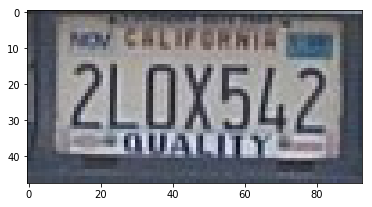

In [7]:
img = cv2.imread("images/image_plate.jpg")

if img.shape[0] > 400:
    scale = 400.0/im.shape[0]
else: scale = 1
img = resize(img, scale)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Prep the Lic Plate image

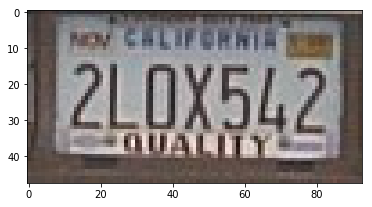

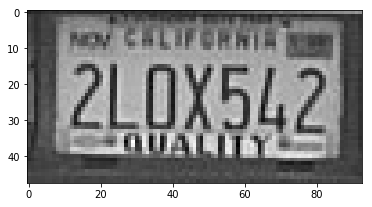

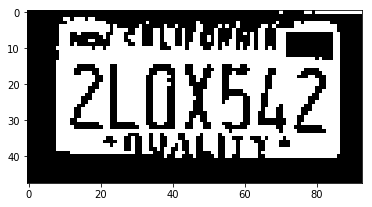

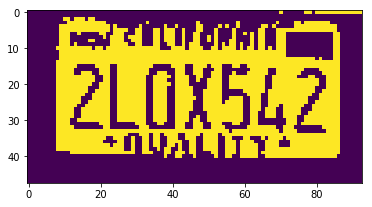

In [8]:
pimage, mask = preprocess(img,  [0,0,0], [255, 255, 255])
plt.imshow(pimage)
plt.show()

imgray = cv2.cvtColor(pimage,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray, cmap='gray')
plt.show()

flag, binaryImage = cv2.threshold(imgray, 85, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
plt.imshow(binaryImage, cmap='gray')
plt.show()

im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(im2)
plt.show()

Find areas of intrest

[(17, 8, 2, 1), (50, 7, 1, 2), (60, 6, 1, 1), (55, 4, 1, 1), (33, 3, 1, 1), (8, 2, 79, 39), (69, 34, 5, 5), (65, 34, 3, 3), (20, 34, 6, 5), (73, 15, 11, 20), (63, 15, 10, 20), (53, 14, 10, 21), (43, 14, 10, 20), (32, 14, 10, 20), (35, 17, 5, 15), (22, 14, 10, 20), (11, 14, 11, 20), (71, 5, 15, 10), (80, 0, 13, 1), (77, 0, 2, 1), (70, 0, 1, 1)]
21
1


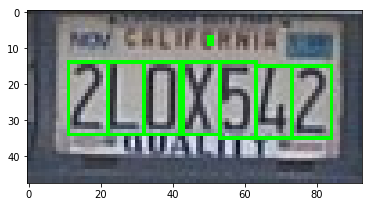

In [9]:
copy = img.copy()
rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

boxes = [cv2.boundingRect(c) for c in contours]
print(boxes)
print(len(boxes))
boxes2 = [b for b in boxes if b[2]*b[3] > 600]
print(len(boxes2))

for x, y, w, h in boxes:
    if not (w/h < .6 and w/h >.4):
        continue
    cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 1)
plt.imshow(rgb)
plt.show()

In [10]:
threshold = .01
real_numbers = []
for x, y, w, h in boxes:
    # not a good ratio
    if not (w/h < .6 and w/h >.4):
        continue


        
    #get slice at box:    
    window = binaryImage[y:y+h, x:x+w]
    window = cv2.resize(window, dims)
    feat = hog.compute(window)
    
    probMap = {}
    for p in platesList:
        probMap[p.character] = p.lsvm.predict_proba(feat.reshape(1,-1))[0][1]
    letter = max(probMap, key=probMap.get)
    if probMap[letter] > threshold:
        real_numbers.append(((x,y,w,h), (letter, probMap[letter])))
print(len(real_numbers))

8


( 11 , 14 )  2
( 22 , 14 )  L
( 32 , 14 )  D
( 43 , 14 )  X
( 53 , 14 )  5
( 63 , 15 )  4
( 73 , 15 )  2
( 50 , 7 )  L


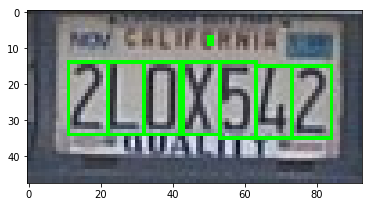

In [11]:
clone = img.copy()

colors = [(0,255,0),(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (1, 1, 1)]
for r in reversed(real_numbers):
    x, y, w, h = r[0]
    letter, prob = r[1]
    print('(',x,',',y,') ',letter)
    cv2.rectangle(clone, (x, y), (x+w, y+h), colors[0], 1)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()
print()

( 7 , 20 )  3
( 18 , 20 )  J
( 29 , 20 )  X
( 41 , 20 )  L
( 53 , 20 )  3
( 64 , 21 )  6
( 77 , 21 )  3
( 14 , 9 )  L


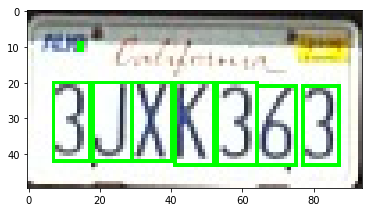

In [12]:
img = cv2.imread("images/lic.jpg")
readPlate(img)

( 17 , 42 )  T
( 8 , 22 )  J
( 42 , 23 )  5
( 74 , 23 )  7
( 140 , 24 )  T
( 183 , 50 )  L
( 173 , 24 )  A
( 204 , 24 )  Z
( 13 , 83 )  9


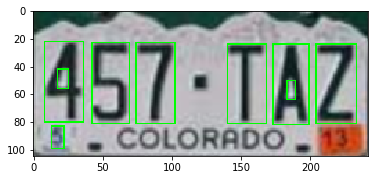

In [13]:
img2 = cv2.imread("hits/hit6.png")
readPlate(img2)